1. Background of Project
2. Hypotheses
3. Summary of Findings and Insights
4. Data Acquisition and Prep
5. Exploratory Data Analysis
6. Feature Engineering
7. Modeling
8. Evaluation

Notes:
- Image use footnote
    - PBS KIDS and the PBS KIDS Logo are registered trademarks of PBS. Used with permission. The contents of PBS KIDS Measure Up! were developed under a grant from the Department of Education. However, those contents do not necessarily represent the policy of the Department of Education, and you should not assume endorsement by the Federal Government. The app is funded by a Ready To Learn grant (PR/AWARD No. U295A150003, CFDA No. 84.295A) provided by the Department of Education to the Corporation for Public Broadcasting.

# Child Learning and Development with PBS KIDS Measure Up! App

![title](mu_image.jpeg)

## I. BACKGROUND

### MEASURE UP! APP  
The PBS KIDS Measure Up! app is designed for children ages 3-5 to develop their comprehension on early STEM concepts. The app takes users to an adventure through three worlds, **Magma Peak** which focuses on capacity and displacement, **Crystal Caves** which is about weight, and finally **Treetop City** which teaches the concepts of length and height.

### 2019 KAGGLE DATA SCIENCE BOWL COMPETITION PRESENTED BY PBS KIDS & BOOZ ALLEN HAMILTON
This year's competition is focused on early childhood education through multimedia learning. Anonymized Measure Up! gameplay data was provided by PBS KIDS. The end product of each submission is to provide a model that predicts the accuracy group of users.

Accuracy group is based on the number of attempts a user makes until s/he completes the "challenge" (a.k.a. assessment). Based on user's performance on each completed assessment, an accuracy group is assigned:
 - 3 - Successfully completed the assessment on 1 attempt
 - 2 - Completed assessment on 2 attempts
 - 1 - Completed assessment on 3 attempts
 - 0 - Completed assessment on more than 3 attempts

The model will help PBS KIDS to improve game design and to discover relationships on game engagement and learning processes.

### THE PROJECT
The project is inspired by 2019's Kaggle Data Science Bowl. By analyzing data publicly provided by PBS KIDS on Kaggle, our team has sought to identify and understand drivers of children’s success on assessments (a.k.a. "challenges") in the app. The insights inform teachers and parents on how well using the different activities in the application prepare 3-5-year old children for the application’s final assessments.

A presentation documenting our findings and recommendations is delivered on Jan 30, 2020.

### PROBLEM STATEMENTS & HYPOTHESES:

**Problem 1:** What are the drivers of users assessment accuracy?  
**Hypothesis:** Historical Performance and Time drive assessment performance.
  
**Problem 2:** Is there a certain path that better prepare users in assessments - with the two paths being, linear progression and random (choose activities at their own will)  
**Hypothesis:** There is no difference in the performance between users who followed a linear progression and those who had random learning path.

> Linear Progression and their corresponding in-game activities are as follows:  
**Exposure** (video clip) → **Exploration** (activity) → **Practice** (game) → **Demonstration** (assessment)

### SUMMARY OF FINDINGS AND INSIGHTS

### CONCLUSION AND RECOMMENDATION




---

## II. MODULES & LIBRARIES

In [94]:
import pandas as pd
import numpy as np

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings("ignore")

---
## III. DATA ACQUISITION & PREP

---
## IV. EXPLORATORY DATA ANALYSIS 

---
## V. TEST-TRAIN SPLIT & FEATURE ENGINEERING 

Acquire "tidy" data frames with features and y for feature engineering.

In [64]:
# Features on separate data frames
pc = pd.read_csv("practice_counts.csv")
ta = pd.read_csv("title_acc.csv")
qu = pd.read_csv("cris_df.csv")

In [65]:
pc = pc.drop(columns=["Unnamed: 0"]).set_index("installation_id")
ta = ta.drop(columns=["Unnamed: 0"]).set_index("installation_id")
qu.set_index("installation_id",inplace=True)

In [66]:
# Data Frame with accuracy group, i.e., the "y" or target
y = pd.read_csv("last_assessments.csv")
y = y[["installation_id","accuracy_group"]].set_index("installation_id")

Join the features and target data frames.  
Check first if everything have the same shape.

In [67]:
print(f"Features Shape: {features.shape}")
print(f"y Shape: {y.shape}")

Features Shape: (3523, 33)
y Shape: (3523, 1)


In [68]:
features = pc.join([ta,qu,y])
features.head()

,crystalcaves,magamapeak,treetopcity,bird_med,cart_med,cauld_med,chest_med,shroom_med,bird_mean,cart_mean,...,max_ceiling,low_score,median_score,no_actions,no_incorrect,acc_tendency_high_scorer,acc_tendency_low_scorer,acc_tendency_mid_scorer,acc_tendency_random_scorer,accuracy_group
installation_id,,,,,,,,,,,,,,,,,,,,,
0006a69f,0.0,725.0,1878.0,0.0,0.0,0.0,0.0,1.0,0.256637,0.0,...,1.0,0.0,0.5,244,999.0,1,0,0,0,3.0
0006c192,204.0,1336.0,664.0,0.5,0.0,1.0,0.0,0.0,0.500000,0.0,...,1.0,0.0,0.5,338,659.0,0,0,1,0,2.0
00129856,0.0,0.0,43.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.0,...,1.0,1.0,1.0,40,0.0,1,0,0,0,3.0
001d0ed0,246.0,0.0,159.0,0.0,1.0,0.0,0.0,0.5,0.000000,1.0,...,1.0,0.0,0.5,192,343.0,0,1,0,0,0.0
00225f67,0.0,0.0,636.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,36,72.0,0,1,0,0,0.0


### Scale

In [69]:
scaled_features = features.copy().drop(columns="accuracy_group")

In [70]:
scaled_features.head()

,crystalcaves,magamapeak,treetopcity,bird_med,cart_med,cauld_med,chest_med,shroom_med,bird_mean,cart_mean,...,shroom_max,max_ceiling,low_score,median_score,no_actions,no_incorrect,acc_tendency_high_scorer,acc_tendency_low_scorer,acc_tendency_mid_scorer,acc_tendency_random_scorer
installation_id,,,,,,,,,,,,,,,,,,,,,
0006a69f,0.0,725.0,1878.0,0.0,0.0,0.0,0.0,1.0,0.256637,0.0,...,1.0,1.0,0.0,0.5,244,999.0,1,0,0,0
0006c192,204.0,1336.0,664.0,0.5,0.0,1.0,0.0,0.0,0.500000,0.0,...,0.0,1.0,0.0,0.5,338,659.0,0,0,1,0
00129856,0.0,0.0,43.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.0,...,0.0,1.0,1.0,1.0,40,0.0,1,0,0,0
001d0ed0,246.0,0.0,159.0,0.0,1.0,0.0,0.0,0.5,0.000000,1.0,...,1.0,1.0,0.0,0.5,192,343.0,0,1,0,0
00225f67,0.0,0.0,636.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,36,72.0,0,1,0,0


In [72]:
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(scaled_features),columns=scaled_features.columns).set_index([scaled_features.index])

In [74]:
scaled_features.head()

,crystalcaves,magamapeak,treetopcity,bird_med,cart_med,cauld_med,chest_med,shroom_med,bird_mean,cart_mean,...,shroom_max,max_ceiling,low_score,median_score,no_actions,no_incorrect,acc_tendency_high_scorer,acc_tendency_low_scorer,acc_tendency_mid_scorer,acc_tendency_random_scorer
installation_id,,,,,,,,,,,,,,,,,,,,,
0006a69f,-0.697495,0.085157,2.104294,-0.528014,-0.871638,-0.865103,-0.376398,1.373563,0.269373,-0.903912,...,1.234348,0.559604,-0.796056,-0.021473,0.194814,0.121308,1.106398,-0.655583,-0.339970,-0.413775
0006c192,-0.386885,0.681908,0.293211,1.054643,-0.871638,1.361270,-0.376398,-0.827919,1.044428,-0.903912,...,-0.883506,0.559604,-0.796056,-0.021473,0.640813,0.015279,-0.903834,-0.655583,2.941438,-0.413775
00129856,-0.697495,-0.622934,-0.633216,2.637299,-0.871638,-0.865103,-0.376398,-0.827919,2.636813,-0.903912,...,-0.883506,0.559604,1.684480,1.186022,-0.773098,-0.190230,1.106398,-0.655583,-0.339970,-0.413775
001d0ed0,-0.322935,-0.622934,-0.460164,-0.528014,1.309025,-0.865103,-0.376398,0.272822,-0.547958,1.314053,...,1.234348,0.559604,-0.796056,-0.021473,-0.051909,-0.083266,-0.903834,1.525360,-0.339970,-0.413775
00225f67,-0.697495,-0.622934,0.251440,-0.528014,-0.871638,-0.865103,-0.376398,-0.827919,-0.547958,-0.903912,...,-0.883506,-2.155483,-0.796056,-1.228967,-0.792077,-0.167777,-0.903834,1.525360,-0.339970,-0.413775


In [77]:
df_feed = scaled_features.copy()

### Train-Test Split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df_feed,y, test_size=0.3, stratify=y["accuracy_group"],random_state=123)

### Feature Engineering

In [88]:
lasso = LassoCV()
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [89]:
print(f"Best alpha using built-in LassoCV: {lasso.alpha_}")
print(f"Best score using built-in LassoCV: {lasso.score(X_train,y_train)}")

Best alpha using built-in LassoCV: 0.003949943493827805
Best score using built-in LassoCV: 0.6161412165596222


In [92]:
coef = pd.Series(lasso.coef_, index = X_train.columns)

In [93]:
coef

 crystalcaves                -0.016245
magamapeak                    0.056289
treetopcity                  -0.038507
bird_med                      0.000000
cart_med                      0.019951
cauld_med                     0.107676
chest_med                    -0.004774
shroom_med                    0.117808
bird_mean                     0.000000
cart_mean                     0.000000
cauld_mean                    0.000000
chest_mean                    0.000000
shroom_mean                   0.000000
bird_min                     -0.049326
cart_min                      0.017097
cauld_min                     0.000000
chest_min                    -0.033514
shroom_min                    0.014788
bird_max                      0.097924
cart_max                      0.039698
cauld_max                     0.005899
chest_max                     0.047344
shroom_max                   -0.050566
max_ceiling                   0.283158
low_score                     0.463835
median_score             

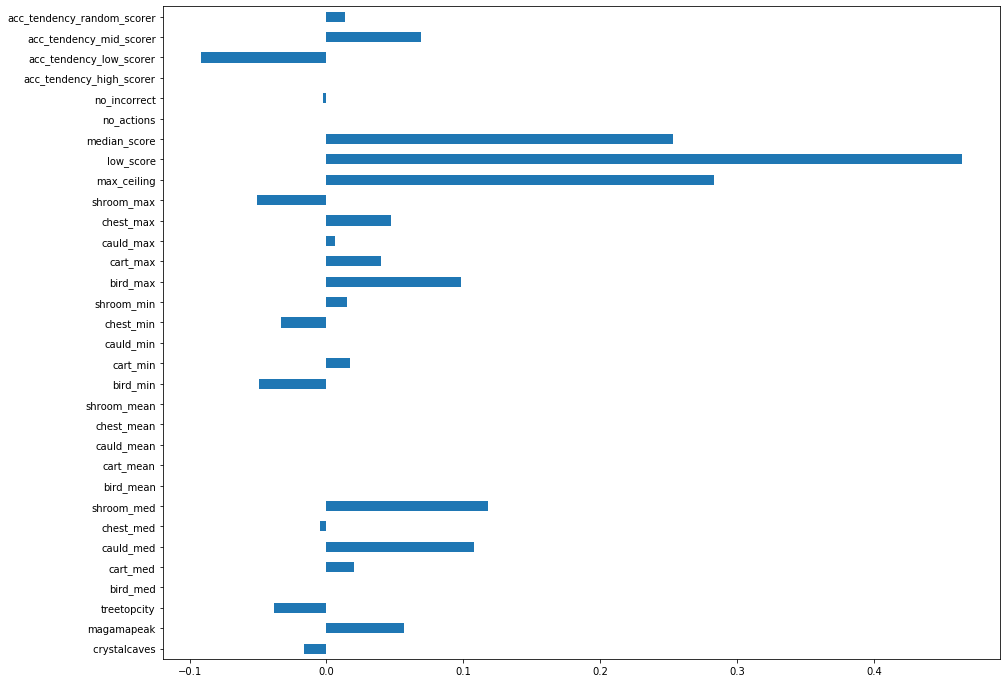

In [98]:
coef.plot(kind="barh",figsize=(15,12))

---
## VI. MODELING